In [1]:
from sqlalchemy import create_engine
from sqlalchemy.orm import sessionmaker

engine = create_engine("sqlite:///./app/connection/test.db", echo=False)
SessionLocal = sessionmaker(autocommit=False, autoflush=False, bind=engine)
session = SessionLocal()

In [2]:
from app.services.kor_price_service import KorPriceService


kor_price_service = KorPriceService(session)
data = kor_price_service.get_ticker_price_all("005930", is_df=True)

In [3]:
import pandas as pd


data = data[["baseDt", "closePrice"]]
data.set_index("baseDt", inplace=True)
# index를 날짜타입으로 변경(백테스트시 날짜형식이어야함.)
data.index = pd.to_datetime(data.index)

In [4]:
from app.services.trading_services.backtest_service import BacktestService


backtest_service = BacktestService()

buyAndHold = backtest_service.buy_and_hold(data, "HoldAndBuy")
sma = backtest_service.sma("sma", data)

result = backtest_service.run_backtest(buyAndHold, sma)
# 200일 이후 부터 시작하며, 투자시점도 rebase하여 200일 이후를 처음 투자시작점으로 변경한다
final_result = result.prices.iloc[201:].rebase()

final_result.plot()
final_result.to_drawdown_series().plot()  # 낙폭
# 성과지표
result.stats

In [11]:
sma_20 = backtest_service.sma("sma_20", data, 20)
sma_60 = backtest_service.sma("sma_60", data, 60)
sma_100 = backtest_service.sma("sma_100", data, 100)
sma_150 = backtest_service.sma("sma_150", data, 150)
sma_200 = backtest_service.sma("sma_200", data, 200)
sma_250 = backtest_service.sma("sma_250", data, 250)

In [ ]:
result_all = backtest_service.run_backtest(
    sma_20, sma_60, sma_100, sma_150, sma_200, sma_250
)
result_all.prices[250:].rebase().plot()

In [ ]:
######################### 골든크로스, 데드크로스 #########################

from app.services.trading_services.backtest_service import BacktestService


backtest_service = BacktestService()
golden_dead_cross, bind = backtest_service.golden_dead_cross(data)
result = backtest_service.run_backtest(golden_dead_cross)

In [ ]:
result.plot()
result.display_monthly_returns()  # 월별 년도별 수익률

In [ ]:
# signal은 -1,0,1 이므로 스케일이 너무작아 제대로 확인되지 않는다.
# 그래서 signal은 보조축으로 넘겨 y축을 새로 생성한다.
bind.loc["2018":].plot(figsize=(10, 6), secondary_y=["signal"])

In [ ]:
# 특정 기간만 잘라서 확인
pd.concat([bind, result.prices], axis=1).loc["2021"].plot(
    figsize=(10, 6),
    secondary_y=["signal"],
    alpha=0.8,
)

In [ ]:
############### 평균회귀 전략 ##################
from app.services.trading_services.backtest_service import BacktestService


backtest_service = BacktestService()

# RSI
rsi_strategy = backtest_service.rsi(data)
# 볼린저밴드
bb_strategy = backtest_service.bb_band(data)

result = backtest_service.run_backtest(rsi_strategy, bb_strategy)
result.plot()

100%|██████████| 5/5 [00:01<00:00,  2.89it/s]


<Axes: >

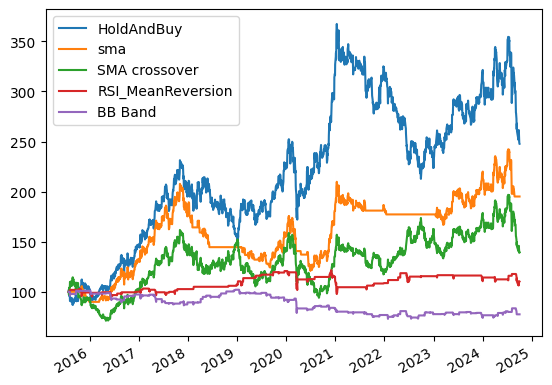

In [5]:
from app.services.trading_services.backtest_service import BacktestService


backtest_service = BacktestService()


buyAndHold = backtest_service.buy_and_hold(data, "HoldAndBuy")
sma = backtest_service.sma("sma", data)
golden_dead_cross, _ = backtest_service.golden_dead_cross(data)
# RSI
rsi_strategy = backtest_service.rsi(data)
# 볼린저밴드
bb_strategy = backtest_service.bb_band(data)

result = backtest_service.run_backtest(
    buyAndHold, sma, golden_dead_cross, rsi_strategy, bb_strategy
)

# 200일 이후 부터 시작하며, 투자시점도 rebase하여 200일 이후를 처음 투자시작점으로 변경한다
final_result = result.prices.iloc[201:].rebase()
final_result.plot()

In [ ]:
# result.prices.loc["2021"].plot()

In [ ]:
# data = bt.get("aapl,msft,c,gs,ge", start="2010-01-01")